# A Simple Demonstration of Coregionalisation

This notebook will show how to construct a multi-output GP model using GPflow. We will consider a regression problem for functions $f: \mathbb{R}^D \rightarrow \mathbb{R}^P$. We assume that the dataset is of the form $(X_1, f_1), \dots, (X_P, f_P)$, i.e. we do not necessarily observe all the outputs for a given input location. In case we have fully observed outputs for each input, please refer to the [multioutput notebook](./multioutput.ipynb) for a more efficient implementation. For this problem, we model $f$ as a *coregionalised* Gaussian process, which assumes a kernel of the form:

$$\textrm{cov}(f_i(X), f_j(X^\prime)) = k(X, X^\prime) \cdot B[i, j].$$

The covariance of the $i$th function at $X$ and the $j$th function at $X^\prime$ is a kernel applied at $X$ and $X^\prime$, times the ($i, j$)th entry of a positive definite $P \times P$-matrix $B$. This is known as the **intrinsic model of coregionalization (ICM)** _(Bonilla and Williams, 2008)_.

To make sure that $B$ is positive-definite, we parameterise it as

$$B = W W^\top + \textrm{diag}(\kappa).$$

To build such model in GPflow, we need to perform the two following steps:

 * Create the kernel function defined above, using the `Coregion` kernel class.
 * Augment the training data with an extra column containing an integer index to indicate which output an observation is associated with. This is essential to make the data work with the `Coregion` kernel.

In [11]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot
np.random.seed(123)

## Data preparation
We start of by generating some training data to fit the model with. For this example, we choose the following two correlated functions for our outputs:
$$
\begin{align}
y_1 &= \sin(6x) + \epsilon_1, \qquad \epsilon_1 \sim \mathcal{N}(0, 0.009) \\
y_2 &= \sin(6x + 0.7) + \epsilon_2, \qquad \epsilon_2 \sim \mathcal{N}(0, 0.01) \\
\end{align}
$$

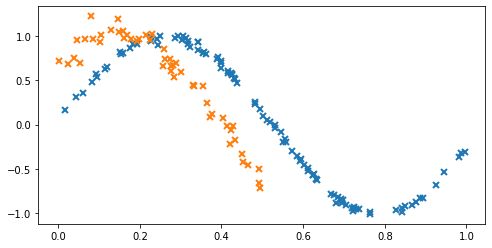

In [12]:
# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1) # Observed locations for first output
X2 = np.random.rand(50, 1) * 0.5 # Observed locations for second output

Y1 = np.sin(6*X1) + np.random.randn(*X1.shape) * 0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.randn(*X2.shape) * 0.1

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2);

## Data formatting for the Coregionalised model
To our training dataset, we add an extra column containing an index that specifies which output is observed.

In [13]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))

# Augment the Y data
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2)))))

## Building the Coregionalisation kernel:
We build a Coregionalisation kernel with the Matern 3/2 kernel as the base kernel. This acts on the leading ([0]) data dimension of the augmented X values. The 'Coregion' kernel indexes the outputs, and acts on the last ([1]) data dimension (indices) of the augmented X values. To specify these dimensions, we use the built-in `active_dims` argument in the kernel constructor. To construct the full multi-output kernel, we take the product of the two kernels (For a more in-depth tutorial on kernel combination see this [notebook](./kernels.ipynb)).

In [14]:
output_dim = 2 # Number of outputs
rank = 1 # Rank of W
k = gpflow.kernels.Matern32(1, active_dims=[0]) # Base kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1]) # Coregion kernel
coreg.W = np.random.rand(output_dim, rank) # Initialise the W matrix
kern = k * coreg

Note that, the default initialisation on W is zeroes; however, this is a saddle point in the objective so the value of W will not be optimised to fit the data. Hence, re-initializing the matrix to random entries should give a more accurate result.

## Constructing the model
The final ingredient to building the model is to specify the likelihood for each output dimension. To do this, we make use of the `SwitchedLikelihood` object in GPflow.

In [19]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()])

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik, num_latent=1)
# Here we specify num_latent=1 to avoid getting two outputs when predicting as Y_augmented is 2-dimensional

# closure
# @tf.function
def objective_closure():
    return m.neg_log_marginal_likelihood()

# fit the covariance function parameters
gpflow.optimizers.Scipy().minimize(objective_closure, m.trainable_variables, options=dict(maxiter=100))

Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.


      fun: -198.7732709485
 hess_inv: array([[ 1.17288599e-02,  6.59772000e-03, -3.91886394e-03, ...,
         7.69143035e-13, -3.04413429e-14,  1.02244318e-03],
       [ 6.59772000e-03,  1.01108063e-01, -1.41173259e-01, ...,
         2.75115735e-12, -7.44155719e-14,  1.29245653e-04],
       [-3.91886394e-03, -1.41173259e-01,  2.35147666e-01, ...,
        -4.66098340e-12,  9.95291705e-14,  1.52292347e-03],
       ...,
       [ 7.69143035e-13,  2.75115735e-12, -4.66098340e-12, ...,
         1.00000000e+00,  1.07118967e-23, -2.56182132e-13],
       [-3.04413429e-14, -7.44155719e-14,  9.95291705e-14, ...,
         1.07118967e-23,  1.00000000e+00, -1.16644821e-13],
       [ 1.02244318e-03,  1.29245653e-04,  1.52292347e-03, ...,
        -2.56182132e-13, -1.16644821e-13,  9.98271574e-01]])
      jac: array([ 3.00176181e+01,  1.15837775e+01,  1.36252908e+01, ...,
       -3.03999540e-13, -2.36892423e-11, -1.40752990e-02])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 

That's it: the model has trained. Let's plot the model fit to see what's happened.

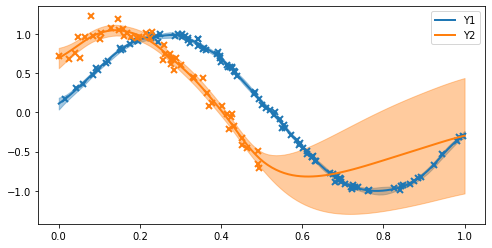

In [20]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(x[:, 0], 
                     (mu - 2*np.sqrt(var))[:, 0], 
                     (mu + 2*np.sqrt(var))[:, 0], 
                     color=color, alpha=0.4)

def plot(m):
    plt.figure(figsize=(8, 4))
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(X1, Y1, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'Y1')

    line, = plt.plot(X2, Y2, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'Y2')
    
    plt.legend()

plot(m)

From the plots we see:

 - The first function (blue) has low posterior variance everywhere because there are so many observations, and the noise variance is small. 
 - The second function (orange) has higher posterior variance near the data, because the data are more noisy, and very high posterior variance where there are no observations (x > 0.5). 
 - The model has done a reasonable job of estimating the noise variance and lengthscales.
 - The model recognises the correlation between the two functions and is able to suggest (with uncertainty) that as x > 0.5 the orange curve should follow the blue curve (which we know to be the truth from the data generating procedure above).
 
The covariance matrix between outputs is as follows:

B = tf.Tensor(
[[0.95800411 0.84378617]
 [0.93945757 0.82982659]], shape=(2, 2), dtype=float64)


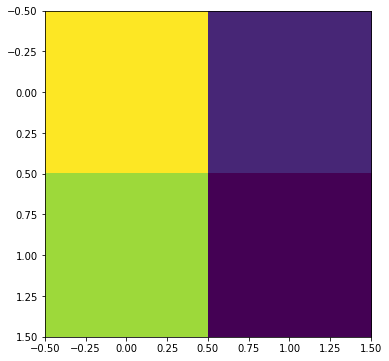

In [35]:
B = coreg.W @ coreg.W.T + coreg.kappa
print('B =', B)
plt.imshow(B);

## Further Reading:
- [Kernels](../advanced/kernels.ipynb), explaining advanced usage of GPflow kernels
- [Multioutput](./multioutput.ipynb), which details other GPflow features for multi-output prediction.

## References:

Bonilla, Edwin V., Kian M. Chai, and Christopher Williams. "Multi-task Gaussian process prediction." Advances in neural information processing systems. 2008.